In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import time
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# Set seeds
torch.manual_seed(42)
np.random.seed(42)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar100/meta
/kaggle/input/cifar100/file.txt
/kaggle/input/cifar100/test
/kaggle/input/cifar100/train


# 1. Data Preparation (No GrayScale)

In [2]:
use_grayscale = False  # Set True for grayscale model

if use_grayscale:
    transform_train = transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
else:
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,)*3, (0.5,)*3)
    ])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

class_names = test_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("1. Done")

100%|██████████| 169M/169M [00:03<00:00, 43.7MB/s] 


Using device: cuda
1. Done


# 2. Custom CNN (func)

In [3]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100, in_channels=3):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


# Model Analysis + Plots

In [4]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ModelAnalyzer:
    def __init__(self, class_names):
        self.class_names = class_names
        self.results = {}
        self.training_histories = {}
        
    def analyze_dataset(self, train_dataset, test_dataset, save_dir='plots'):
        """Analyze and plot dataset characteristics"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Get class distributions
        train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
        
        train_counts = Counter(train_labels)
        test_counts = Counter(test_labels)
        
        # Plot class distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Training set distribution
        classes = list(range(len(self.class_names)))
        train_dist = [train_counts[i] for i in classes]
        test_dist = [test_counts[i] for i in classes]
        
        ax1.bar(classes, train_dist, alpha=0.7, color='skyblue')
        ax1.set_title('Training Set Class Distribution', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Class Index', fontsize=12)
        ax1.set_ylabel('Number of Samples', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Test set distribution
        ax2.bar(classes, test_dist, alpha=0.7, color='lightcoral')
        ax2.set_title('Test Set Class Distribution', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Class Index', fontsize=12)
        ax2.set_ylabel('Number of Samples', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/dataset_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Dataset statistics
        print(f"Dataset Statistics:")
        print(f"Training samples: {len(train_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        print(f"Number of classes: {len(self.class_names)}")
        print(f"Average samples per class (train): {len(train_dataset)/len(self.class_names):.1f}")
        print(f"Average samples per class (test): {len(test_dataset)/len(self.class_names):.1f}")
        
    def enhanced_train_model(self, model, train_loader, val_loader, device, epochs=50, lr=0.001, model_name="Model"):
        """Enhanced training function with comprehensive logging"""
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
        
        # Training history
        history = {
            'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 
            'learning_rates': [], 'epochs': []
        }
        
        best_val_loss = float('inf')  # Changed from best_val_acc to match your original
        patience_counter = 0
        early_stopping_patience = 20
        
        start_time = time.time()
        
        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for images, labels in train_loader:  # Removed tqdm to match your original
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct_val / total_val
            
            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['learning_rates'].append(optimizer.param_groups[0]['lr'])
            history['epochs'].append(epoch + 1)
            
            scheduler.step(val_loss)
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Early stopping - Fixed to match your original logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"{model_name}_best.pth")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping!")
                    break
        
        training_time = time.time() - start_time
        history['training_time'] = training_time
        
        self.training_histories[model_name] = history
        return history
    
    def comprehensive_evaluate(self, model, test_loader, device, model_name="Model"):
        """Comprehensive model evaluation with multiple metrics"""
        model.eval()
        model = model.to(device)
        
        y_true = []
        y_pred = []
        y_probs = []
        test_loss = 0.0
        criterion = nn.CrossEntropyLoss()
        
        start_time = time.time()
        
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_probs.extend(probabilities.cpu().numpy())
        
        inference_time = (time.time() - start_time) / len(test_loader.dataset)
        test_loss = test_loss / len(test_loader)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred) * 100
        top5_accuracy = top_k_accuracy_score(y_true, y_probs, k=5) * 100
        
        # Model complexity metrics
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Model size (approximate)
        model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)  # MB
        
        # Store results
        self.results[model_name] = {
            'accuracy': accuracy,
            'top5_accuracy': top5_accuracy,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'model_size_mb': model_size,
            'test_loss': test_loss,
            'inference_time': inference_time,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_probs': y_probs
        }
        
        return y_pred, y_true, y_probs
    
    def plot_training_curves(self, save_dir='plots'):
        """Plot training curves for all models"""
        os.makedirs(save_dir, exist_ok=True)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        for model_name, history in self.training_histories.items():
            epochs = history['epochs']
            
            # Loss curves
            axes[0, 0].plot(epochs, history['train_loss'], label=f'{model_name} - Train', marker='o', markersize=4)
            axes[0, 0].plot(epochs, history['val_loss'], label=f'{model_name} - Val', marker='s', markersize=4)
            
            # Accuracy curves
            axes[0, 1].plot(epochs, history['train_acc'], label=f'{model_name} - Train', marker='o', markersize=4)
            axes[0, 1].plot(epochs, history['val_acc'], label=f'{model_name} - Val', marker='s', markersize=4)
            
            # Learning rate
            axes[1, 0].plot(epochs, history['learning_rates'], label=f'{model_name}', marker='d', markersize=4)
        
        # Loss subplot
        axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy subplot
        axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Learning rate subplot
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Training time comparison
        model_names = list(self.training_histories.keys())
        training_times = [self.training_histories[name]['training_time']/60 for name in model_names]  # Convert to minutes
        
        axes[1, 1].bar(model_names, training_times, color=['skyblue', 'lightcoral', 'lightgreen'])
        axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Time (minutes)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_confusion_matrices(self, top_n=15, save_dir='plots'):
        """Plot confusion matrices for all models"""
        os.makedirs(save_dir, exist_ok=True)
        
        n_models = len(self.results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
        if n_models == 1:
            axes = [axes]
        
        for i, (model_name, results) in enumerate(self.results.items()):
            y_true = results['y_true']
            y_pred = results['y_pred']
            
            # Get top-n most frequent classes
            class_counts = Counter(y_true)
            top_classes = [cls for cls, _ in class_counts.most_common(top_n)]
            
            # Filter predictions and true labels for top classes
            mask = np.isin(y_true, top_classes)
            y_true_filtered = np.array(y_true)[mask]
            y_pred_filtered = np.array(y_pred)[mask]
            
            # Create confusion matrix
            cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
            
            # Plot
            im = axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            axes[i].set_title(f'{model_name}\nConfusion Matrix (Top {top_n} Classes)', fontweight='bold')
            
            # Add text annotations
            thresh = cm.max() / 2.
            for row in range(cm.shape[0]):
                for col in range(cm.shape[1]):
                    axes[i].text(col, row, format(cm[row, col], 'd'),
                               ha="center", va="center",
                               color="white" if cm[row, col] > thresh else "black")
            
            axes[i].set_xlabel('Predicted Label')
            axes[i].set_ylabel('True Label')
            
            # Set ticks
            tick_marks = np.arange(len(top_classes))
            axes[i].set_xticks(tick_marks)
            axes[i].set_yticks(tick_marks)
            axes[i].set_xticklabels([self.class_names[i] for i in top_classes], rotation=45, ha='right')
            axes[i].set_yticklabels([self.class_names[i] for i in top_classes])
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_per_class_accuracy(self, save_dir='plots'):
        """Plot per-class accuracy for all models"""
        os.makedirs(save_dir, exist_ok=True)
        
        fig, axes = plt.subplots(len(self.results), 1, figsize=(20, 6*len(self.results)))
        if len(self.results) == 1:
            axes = [axes]
        
        for i, (model_name, results) in enumerate(self.results.items()):
            y_true = results['y_true']
            y_pred = results['y_pred']
            
            # Calculate per-class accuracy
            per_class_acc = []
            for class_idx in range(len(self.class_names)):
                class_mask = np.array(y_true) == class_idx
                if np.sum(class_mask) > 0:
                    class_acc = np.sum(np.array(y_pred)[class_mask] == class_idx) / np.sum(class_mask)
                    per_class_acc.append(class_acc * 100)
                else:
                    per_class_acc.append(0)
            
            # Plot
            x_pos = np.arange(len(self.class_names))
            bars = axes[i].bar(x_pos, per_class_acc, alpha=0.7)
            axes[i].set_title(f'{model_name} - Per-Class Accuracy', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Class Index')
            axes[i].set_ylabel('Accuracy (%)')
            axes[i].set_ylim(0, 100)
            axes[i].grid(True, alpha=0.3)
            
            # Add average line
            avg_acc = np.mean(per_class_acc)
            axes[i].axhline(y=avg_acc, color='red', linestyle='--', alpha=0.8, 
                           label=f'Average: {avg_acc:.1f}%')
            axes[i].legend()
            
            # Color bars based on performance
            for j, bar in enumerate(bars):
                if per_class_acc[j] < 50:
                    bar.set_color('red')
                elif per_class_acc[j] < 75:
                    bar.set_color('orange')
                else:
                    bar.set_color('green')
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/per_class_accuracy.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_misclassified_analysis(self, top_n=10, save_dir='plots'):
        """Analyze and plot most misclassified classes"""
        os.makedirs(save_dir, exist_ok=True)
        
        fig, axes = plt.subplots(len(self.results), 1, figsize=(15, 5*len(self.results)))
        if len(self.results) == 1:
            axes = [axes]
        
        for i, (model_name, results) in enumerate(self.results.items()):
            y_true = results['y_true']
            y_pred = results['y_pred']
            
            # Calculate misclassification count per class
            misclass_count = {}
            for true_label, pred_label in zip(y_true, y_pred):
                if true_label != pred_label:
                    if true_label not in misclass_count:
                        misclass_count[true_label] = 0
                    misclass_count[true_label] += 1
            
            # Get top misclassified classes
            sorted_misclass = sorted(misclass_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
            
            if sorted_misclass:
                classes = [self.class_names[cls] for cls, _ in sorted_misclass]
                counts = [count for _, count in sorted_misclass]
                
                bars = axes[i].bar(range(len(classes)), counts, color='salmon', alpha=0.7)
                axes[i].set_title(f'{model_name} - Top {top_n} Most Misclassified Classes', fontweight='bold')
                axes[i].set_xlabel('Class')
                axes[i].set_ylabel('Misclassification Count')
                axes[i].set_xticks(range(len(classes)))
                axes[i].set_xticklabels(classes, rotation=45, ha='right')
                axes[i].grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar, count in zip(bars, counts):
                    height = bar.get_height()
                    axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                               f'{count}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/misclassified_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_model_comparison(self, save_dir='plots'):
        """Create comprehensive model comparison plots"""
        os.makedirs(save_dir, exist_ok=True)
        
        if len(self.results) < 2:
            print("Need at least 2 models for comparison")
            return
        
        # Prepare data
        models = list(self.results.keys())
        metrics = ['accuracy', 'top5_accuracy', 'total_params', 'model_size_mb', 'test_loss', 'inference_time']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            values = [self.results[model][metric] for model in models]
            
            bars = axes[i].bar(models, values, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'][:len(models)])
            
            # Formatting based on metric
            if metric == 'accuracy' or metric == 'top5_accuracy':
                axes[i].set_ylabel('Accuracy (%)')
                axes[i].set_ylim(0, 100)
                title = 'Accuracy' if metric == 'accuracy' else 'Top-5 Accuracy'
            elif metric == 'total_params':
                axes[i].set_ylabel('Parameters (M)')
                values = [v/1e6 for v in values]  # Convert to millions
                bars = axes[i].bar(models, values, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'][:len(models)])
                title = 'Model Parameters'
            elif metric == 'model_size_mb':
                axes[i].set_ylabel('Size (MB)')
                title = 'Model Size'
            elif metric == 'test_loss':
                axes[i].set_ylabel('Loss')
                title = 'Test Loss'
            elif metric == 'inference_time':
                axes[i].set_ylabel('Time (ms)')
                values = [v*1000 for v in values]  # Convert to milliseconds
                bars = axes[i].bar(models, values, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'][:len(models)])
                title = 'Inference Time per Sample'
            
            axes[i].set_title(title, fontweight='bold')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, values if metric not in ['total_params', 'inference_time'] else 
                                 ([v/1e6 for v in [self.results[model][metric] for model in models]] if metric == 'total_params' else
                                  [v*1000 for v in [self.results[model][metric] for model in models]])):
                height = bar.get_height()
                if metric in ['accuracy', 'top5_accuracy']:
                    label = f'{value:.1f}%'
                elif metric == 'total_params':
                    label = f'{value:.1f}M'
                elif metric == 'inference_time':
                    label = f'{value:.2f}ms'
                else:
                    label = f'{value:.3f}'
                
                axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                           label, ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_results_table(self, save_dir='plots'):
        """Create a comprehensive results table"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Prepare data for table
        table_data = []
        for model_name, results in self.results.items():
            row = {
                'Model': model_name,
                'Accuracy (%)': f"{results['accuracy']:.2f}",
                'Top-5 Accuracy (%)': f"{results['top5_accuracy']:.2f}",
                'Parameters (M)': f"{results['total_params']/1e6:.2f}",
                'Model Size (MB)': f"{results['model_size_mb']:.2f}",
                'Test Loss': f"{results['test_loss']:.4f}",
                'Inference Time (ms)': f"{results['inference_time']*1000:.2f}",
            }
            
            # Add training time if available
            if model_name in self.training_histories:
                row['Training Time (min)'] = f"{self.training_histories[model_name]['training_time']/60:.1f}"
                row['Val Loss'] = f"{min(self.training_histories[model_name]['val_loss']):.4f}"
            
            table_data.append(row)
        
        # Create DataFrame
        df = pd.DataFrame(table_data)
        
        # Create table plot
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.axis('tight')
        ax.axis('off')
        
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.8)
        
        # Style the table
        for i in range(len(df.columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color rows alternately
        for i in range(1, len(df) + 1):
            for j in range(len(df.columns)):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#f0f0f0')
        
        plt.title('Model Performance Comparison Table', fontsize=16, fontweight='bold', pad=20)
        plt.savefig(f'{save_dir}/results_table.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # # Save as CSV
        # df.to_csv(f'{save_dir}/results_table.csv', index=False)
        # print(f"Results table saved to {save_dir}/results_table.csv")
        
        # return df
    
    def generate_all_plots(self, save_dir='plots'):
        """Generate all plots and analysis"""
        print("Generating comprehensive analysis plots...")
        
        self.plot_training_curves(save_dir)
        self.plot_confusion_matrices(save_dir=save_dir)
        self.plot_per_class_accuracy(save_dir)
        self.plot_misclassified_analysis(save_dir=save_dir)
        self.plot_model_comparison(save_dir)
        self.create_results_table(save_dir)
        
        print(f"All plots saved to {save_dir}/ directory")

# 6. Data Preprocessing ResNet18 + EffcientNetB0

# Resnet18 / EfficientNetB0

In [5]:
def get_resnet18_model():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
    return model

In [6]:
def get_efficientnet_model():
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 100)
    return model

# Plots

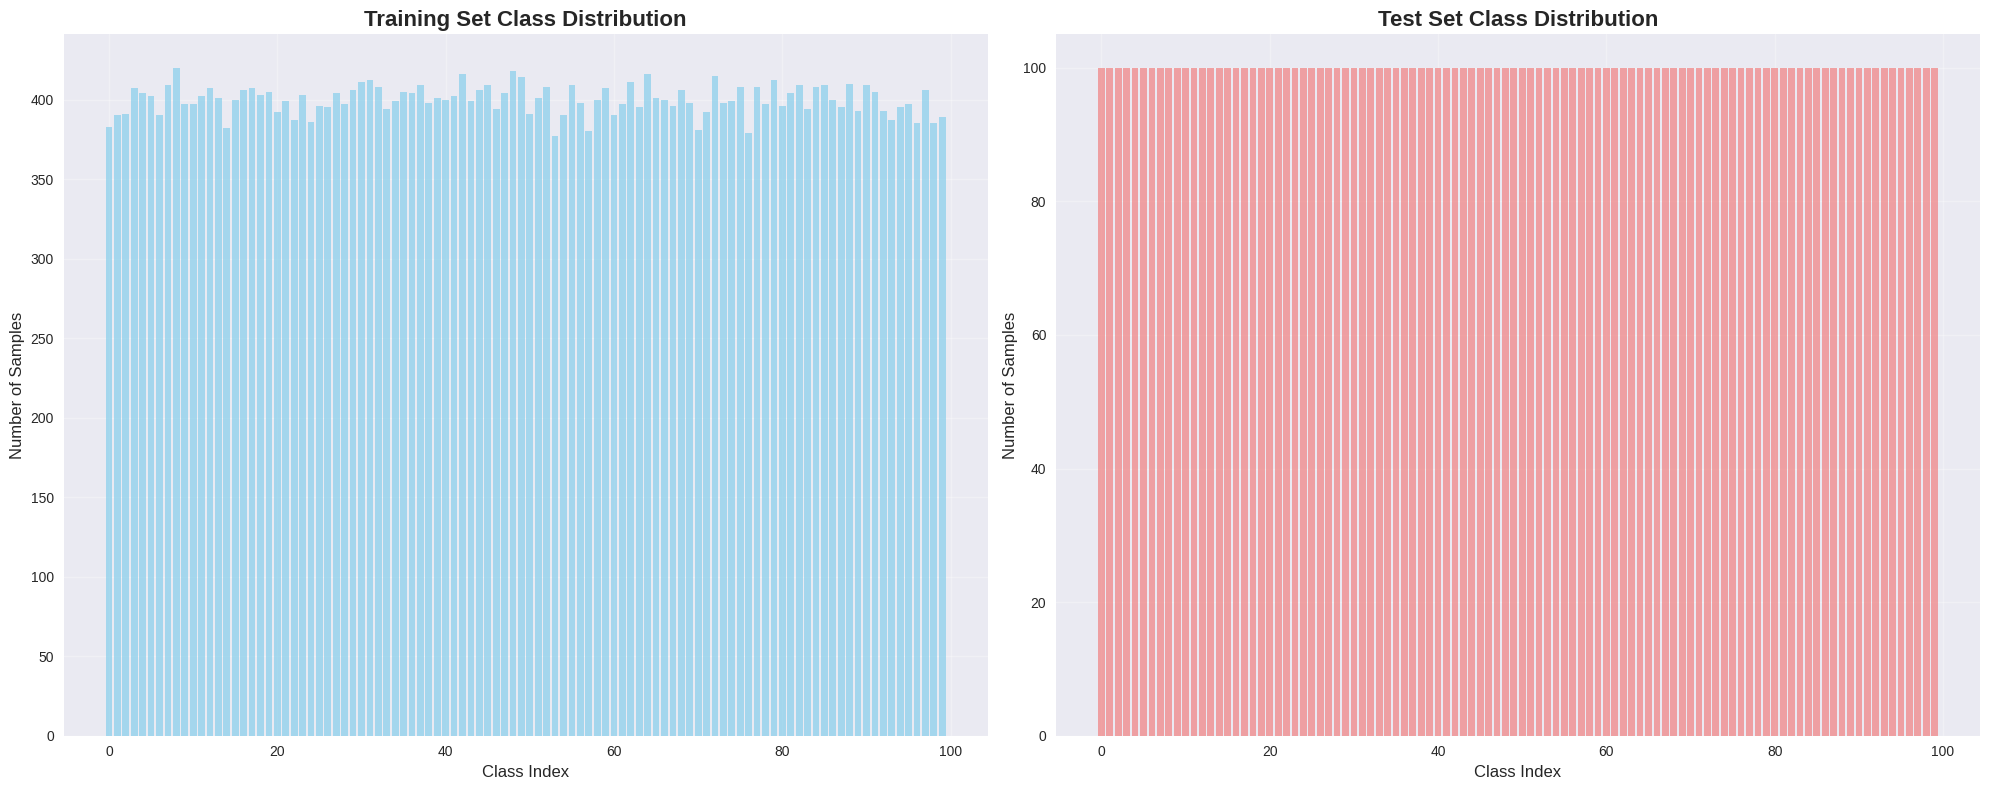

Dataset Statistics:
Training samples: 40000
Test samples: 10000
Number of classes: 100
Average samples per class (train): 400.0
Average samples per class (test): 100.0


In [7]:
# Initialize analyzer
analyzer = ModelAnalyzer(class_names)

# Analyze dataset
analyzer.analyze_dataset(train_dataset, test_dataset)

In [8]:
# Model 1: CustomCNN
model1 = CustomCNN(num_classes=100, in_channels=3)
history1 = analyzer.enhanced_train_model(model1, train_loader, val_loader, device, epochs=50, model_name="CustomCNN")
model1.load_state_dict(torch.load("CustomCNN_best.pth"))
analyzer.comprehensive_evaluate(model1, test_loader, device, "CustomCNN")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 4.2264, Train Acc: 4.34%, Val Loss: 3.9172, Val Acc: 8.55%
Epoch 2: Train Loss: 3.9343, Train Acc: 7.80%, Val Loss: 3.8664, Val Acc: 9.41%
Epoch 3: Train Loss: 3.7440, Train Acc: 10.46%, Val Loss: 3.5690, Val Acc: 13.62%
Epoch 4: Train Loss: 3.5509, Train Acc: 13.69%, Val Loss: 3.4209, Val Acc: 16.19%
Epoch 5: Train Loss: 3.3582, Train Acc: 17.06%, Val Loss: 3.1961, Val Acc: 19.37%
Epoch 6: Train Loss: 3.1845, Train Acc: 19.99%, Val Loss: 3.0460, Val Acc: 22.93%
Epoch 7: Train Loss: 3.0262, Train Acc: 23.32%, Val Loss: 2.8812, Val Acc: 26.13%
Epoch 8: Train Loss: 2.8865, Train Acc: 25.91%, Val Loss: 2.6604, Val Acc: 30.76%
Epoch 9: Train Loss: 2.7417, Train Acc: 28.77%, Val Loss: 2.7201, Val Acc: 29.68%
Epoch 10: Train Loss: 2.6184, Train Acc: 31.88%, Val Loss: 2.5587, Val Acc: 33.38%
Epoch 11: Train Loss: 2.4998, Train Acc: 34.61%, Val Loss: 2.4907, Val Acc: 35.11%
Epoch 12: Train Loss: 2.3990, Train Acc: 36.59%, Val Loss: 2.5420, Val Acc: 35.40%
Epoch 13: Train L

Evaluating: 100%|██████████| 157/157 [00:01<00:00, 87.47it/s]


([68,
  33,
  55,
  51,
  71,
  6,
  29,
  14,
  60,
  0,
  76,
  75,
  81,
  69,
  40,
  43,
  92,
  97,
  70,
  53,
  70,
  49,
  75,
  12,
  21,
  16,
  39,
  8,
  8,
  24,
  20,
  61,
  41,
  73,
  56,
  91,
  58,
  2,
  25,
  37,
  63,
  24,
  39,
  30,
  56,
  22,
  41,
  58,
  75,
  89,
  4,
  6,
  9,
  57,
  64,
  32,
  71,
  52,
  42,
  69,
  77,
  18,
  31,
  33,
  62,
  98,
  43,
  82,
  63,
  92,
  66,
  89,
  28,
  91,
  76,
  32,
  82,
  10,
  77,
  40,
  71,
  78,
  54,
  6,
  26,
  89,
  99,
  42,
  2,
  67,
  22,
  18,
  27,
  21,
  13,
  21,
  32,
  75,
  81,
  84,
  26,
  0,
  52,
  95,
  43,
  69,
  76,
  17,
  57,
  59,
  25,
  20,
  27,
  0,
  9,
  71,
  8,
  43,
  0,
  56,
  85,
  46,
  19,
  92,
  33,
  20,
  3,
  27,
  70,
  35,
  16,
  16,
  1,
  74,
  33,
  91,
  60,
  15,
  52,
  23,
  74,
  11,
  52,
  17,
  24,
  95,
  58,
  39,
  51,
  58,
  58,
  77,
  66,
  49,
  45,
  4,
  58,
  20,
  79,
  88,
  36,
  8,
  16,
  10,
  66,
  59,
  54,
  50,
  78,
  83,

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, efficientnet_b0
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define transforms
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet18 & EfficientNet expect 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # CIFAR-100 mean/std
])

# Load CIFAR-100
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# ResNet18

In [10]:
# Model 2: ResNet18
model2 = get_resnet18_model()
history2 = analyzer.enhanced_train_model(model2, train_loader, val_loader, device, epochs=50, model_name="ResNet18")
analyzer.comprehensive_evaluate(model2, test_loader, device, "ResNet18")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.7MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch 1: Train Loss: 3.6237, Train Acc: 14.65%, Val Loss: 3.4906, Val Acc: 18.21%
Epoch 2: Train Loss: 2.9766, Train Acc: 25.37%, Val Loss: 2.9056, Val Acc: 27.79%
Epoch 3: Train Loss: 2.7611, Train Acc: 29.65%, Val Loss: 2.7278, Val Acc: 30.64%
Epoch 4: Train Loss: 2.6132, Train Acc: 32.58%, Val Loss: 2.6177, Val Acc: 33.22%
Epoch 5: Train Loss: 2.5052, Train Acc: 35.04%, Val Loss: 2.5810, Val Acc: 34.25%
Epoch 6: Train Loss: 2.3921, Train Acc: 37.42%, Val Loss: 2.4307, Val Acc: 36.89%
Epoch 7: Train Loss: 2.3572, Train Acc: 38.05%, Val Loss: 2.4875, Val Acc: 35.48%
Epoch 8: Train Loss: 2.2606, Train Acc: 39.87%, Val Loss: 2.4134, Val Acc: 37.86%
Epoch 9: Train Loss: 2.1884, Train Acc: 41.64%, Val Loss: 2.3514, Val Acc: 39.55%
Epoch 10: Train Loss: 2.2118, Train Acc: 41.45%, Val Loss: 2.3498, Val Acc: 39.48%
Epoch 11: Train Loss: 2.1476, Train Acc: 42.48%, Val Loss: 2.2548, Val Acc: 41.87%
Epoch 12: Train Loss: 2.1131, Train Acc: 43.32%, Val Loss: 2.9286, Val Acc: 30.34%
Epoch 13: Tra

Evaluating: 100%|██████████| 157/157 [00:01<00:00, 84.27it/s]


([68,
  37,
  72,
  21,
  71,
  79,
  27,
  3,
  23,
  0,
  12,
  75,
  81,
  69,
  40,
  43,
  92,
  97,
  70,
  53,
  70,
  49,
  15,
  37,
  21,
  16,
  39,
  8,
  2,
  98,
  20,
  61,
  41,
  30,
  56,
  44,
  58,
  35,
  25,
  81,
  63,
  18,
  39,
  30,
  56,
  22,
  41,
  58,
  84,
  17,
  80,
  15,
  9,
  57,
  11,
  32,
  71,
  52,
  42,
  95,
  77,
  27,
  19,
  38,
  45,
  98,
  43,
  82,
  63,
  92,
  8,
  8,
  61,
  78,
  57,
  32,
  82,
  10,
  77,
  61,
  23,
  78,
  54,
  6,
  29,
  25,
  99,
  8,
  84,
  95,
  61,
  18,
  41,
  21,
  13,
  6,
  73,
  75,
  37,
  84,
  79,
  57,
  47,
  86,
  43,
  69,
  76,
  17,
  57,
  47,
  5,
  20,
  27,
  0,
  9,
  71,
  8,
  43,
  0,
  56,
  90,
  84,
  19,
  62,
  89,
  5,
  3,
  7,
  70,
  11,
  91,
  16,
  90,
  74,
  33,
  91,
  60,
  38,
  52,
  23,
  4,
  11,
  52,
  72,
  18,
  95,
  58,
  39,
  51,
  58,
  58,
  77,
  37,
  49,
  45,
  66,
  58,
  39,
  77,
  42,
  36,
  8,
  87,
  10,
  2,
  59,
  54,
  44,
  89,
  83,
 

# EfficientNet-B0

In [11]:
# Model 3: EfficientNet-B0
model3 = get_efficientnet_model()
history3 = analyzer.enhanced_train_model(model3, train_loader, val_loader, device, epochs=50, model_name="EfficientNet-B0")
analyzer.comprehensive_evaluate(model3, test_loader, device, "EfficientNet-B0")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 151MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr

Epoch 1: Train Loss: 3.5060, Train Acc: 17.51%, Val Loss: 2.7913, Val Acc: 29.08%
Epoch 2: Train Loss: 2.7539, Train Acc: 30.30%, Val Loss: 2.6130, Val Acc: 33.52%
Epoch 3: Train Loss: 2.4823, Train Acc: 35.98%, Val Loss: 2.3191, Val Acc: 38.95%
Epoch 4: Train Loss: 2.3431, Train Acc: 38.50%, Val Loss: 2.2076, Val Acc: 41.67%
Epoch 5: Train Loss: 2.2150, Train Acc: 41.25%, Val Loss: 2.1323, Val Acc: 43.25%
Epoch 6: Train Loss: 2.2578, Train Acc: 40.47%, Val Loss: 2.2909, Val Acc: 42.45%
Epoch 7: Train Loss: 2.1174, Train Acc: 43.25%, Val Loss: 2.1701, Val Acc: 43.63%
Epoch 8: Train Loss: 2.0477, Train Acc: 44.66%, Val Loss: 2.0836, Val Acc: 45.14%
Epoch 9: Train Loss: 2.0039, Train Acc: 45.62%, Val Loss: 2.1211, Val Acc: 44.94%
Epoch 10: Train Loss: 2.0018, Train Acc: 45.75%, Val Loss: 2.0321, Val Acc: 47.25%
Epoch 11: Train Loss: 1.9324, Train Acc: 47.04%, Val Loss: 2.0487, Val Acc: 47.56%
Epoch 12: Train Loss: 1.8676, Train Acc: 48.87%, Val Loss: 1.9347, Val Acc: 48.29%
Epoch 13: Tra

Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.23it/s]


([68,
  80,
  30,
  55,
  23,
  79,
  31,
  14,
  23,
  0,
  12,
  75,
  90,
  69,
  40,
  43,
  92,
  97,
  70,
  53,
  70,
  49,
  48,
  85,
  21,
  16,
  39,
  8,
  8,
  44,
  20,
  22,
  41,
  73,
  56,
  64,
  58,
  35,
  25,
  37,
  65,
  24,
  49,
  30,
  56,
  22,
  41,
  58,
  84,
  34,
  35,
  45,
  9,
  57,
  35,
  32,
  71,
  52,
  42,
  69,
  78,
  27,
  31,
  44,
  62,
  39,
  43,
  6,
  63,
  9,
  38,
  90,
  67,
  91,
  49,
  32,
  82,
  10,
  77,
  61,
  71,
  78,
  54,
  6,
  1,
  89,
  78,
  85,
  35,
  95,
  10,
  18,
  41,
  98,
  81,
  21,
  74,
  7,
  68,
  51,
  26,
  53,
  47,
  86,
  43,
  69,
  76,
  17,
  57,
  59,
  25,
  20,
  1,
  83,
  9,
  71,
  48,
  43,
  0,
  56,
  85,
  84,
  19,
  70,
  33,
  20,
  3,
  27,
  70,
  46,
  11,
  16,
  1,
  74,
  72,
  91,
  60,
  97,
  52,
  23,
  4,
  11,
  52,
  15,
  24,
  95,
  58,
  39,
  51,
  58,
  58,
  77,
  18,
  60,
  45,
  66,
  13,
  39,
  24,
  88,
  36,
  5,
  87,
  10,
  72,
  47,
  54,
  80,
  51,
  

# Plots

Generating comprehensive analysis plots...


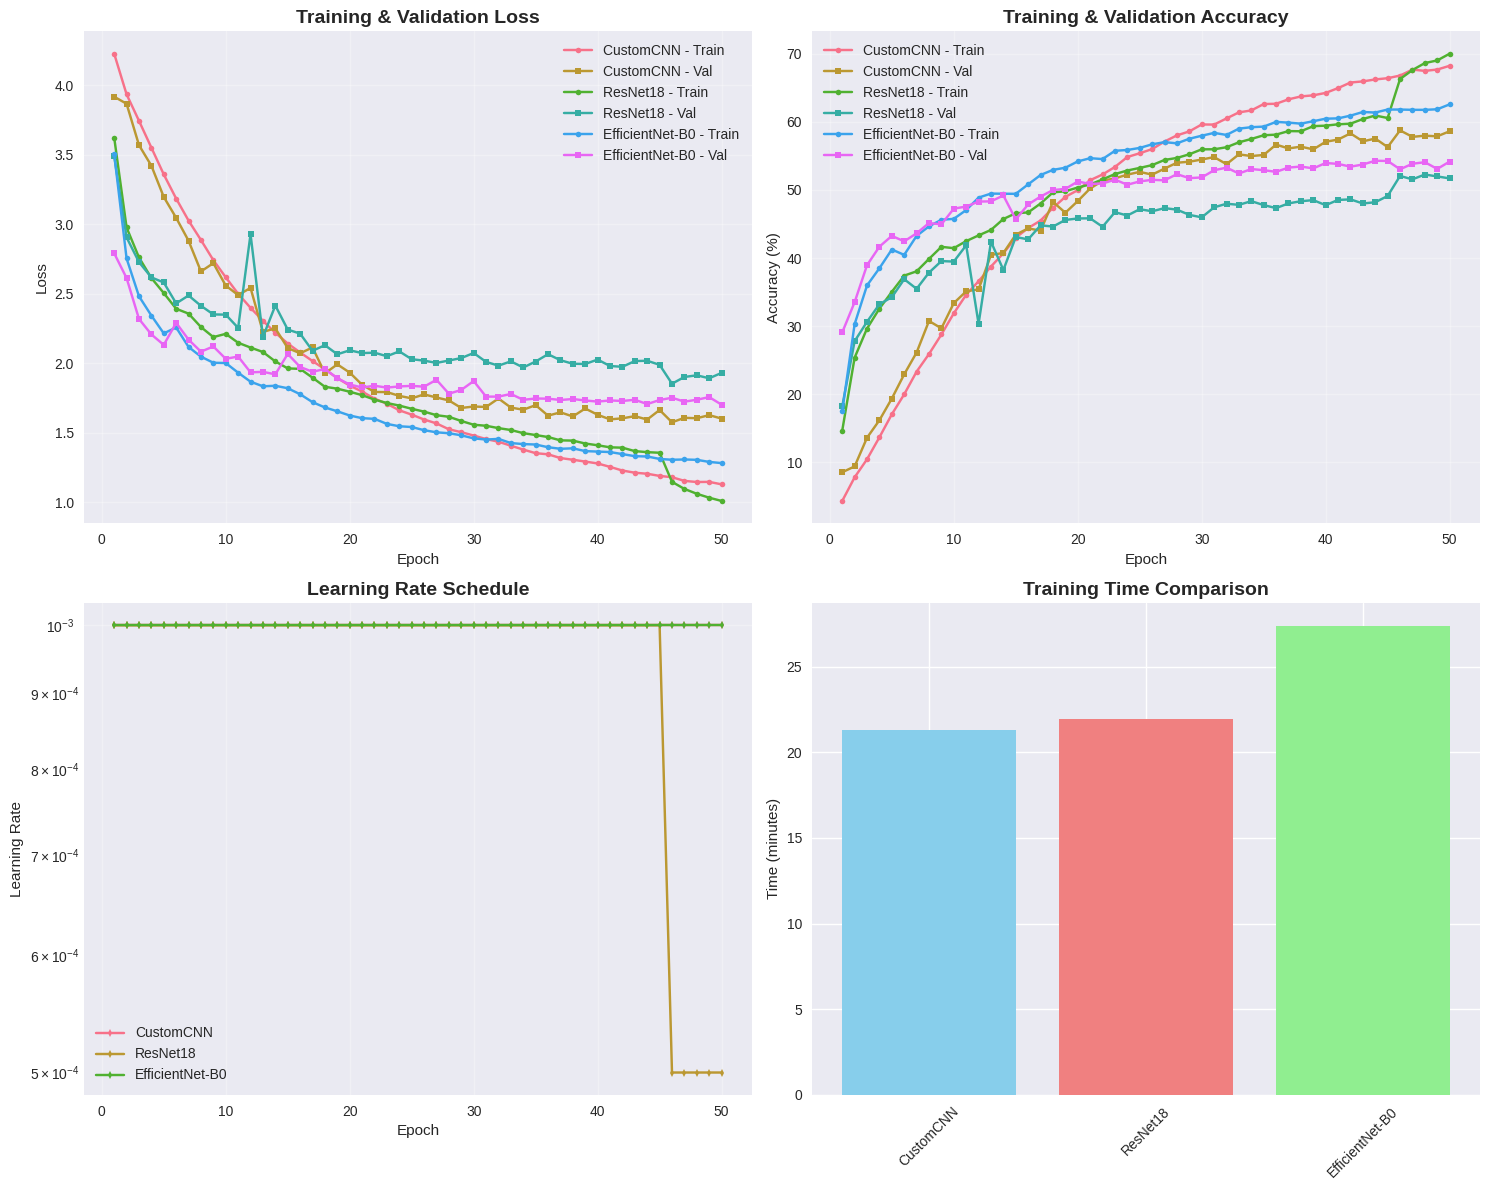

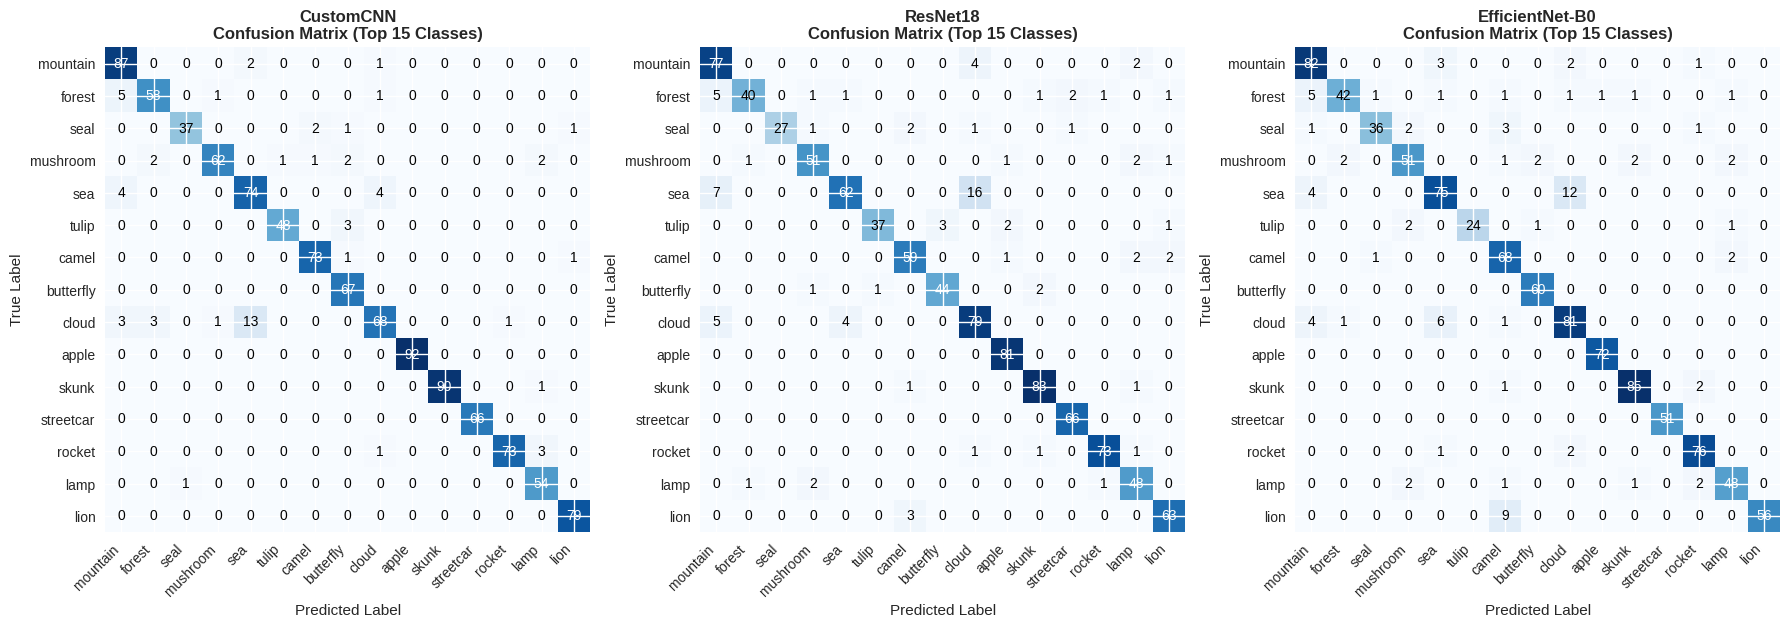

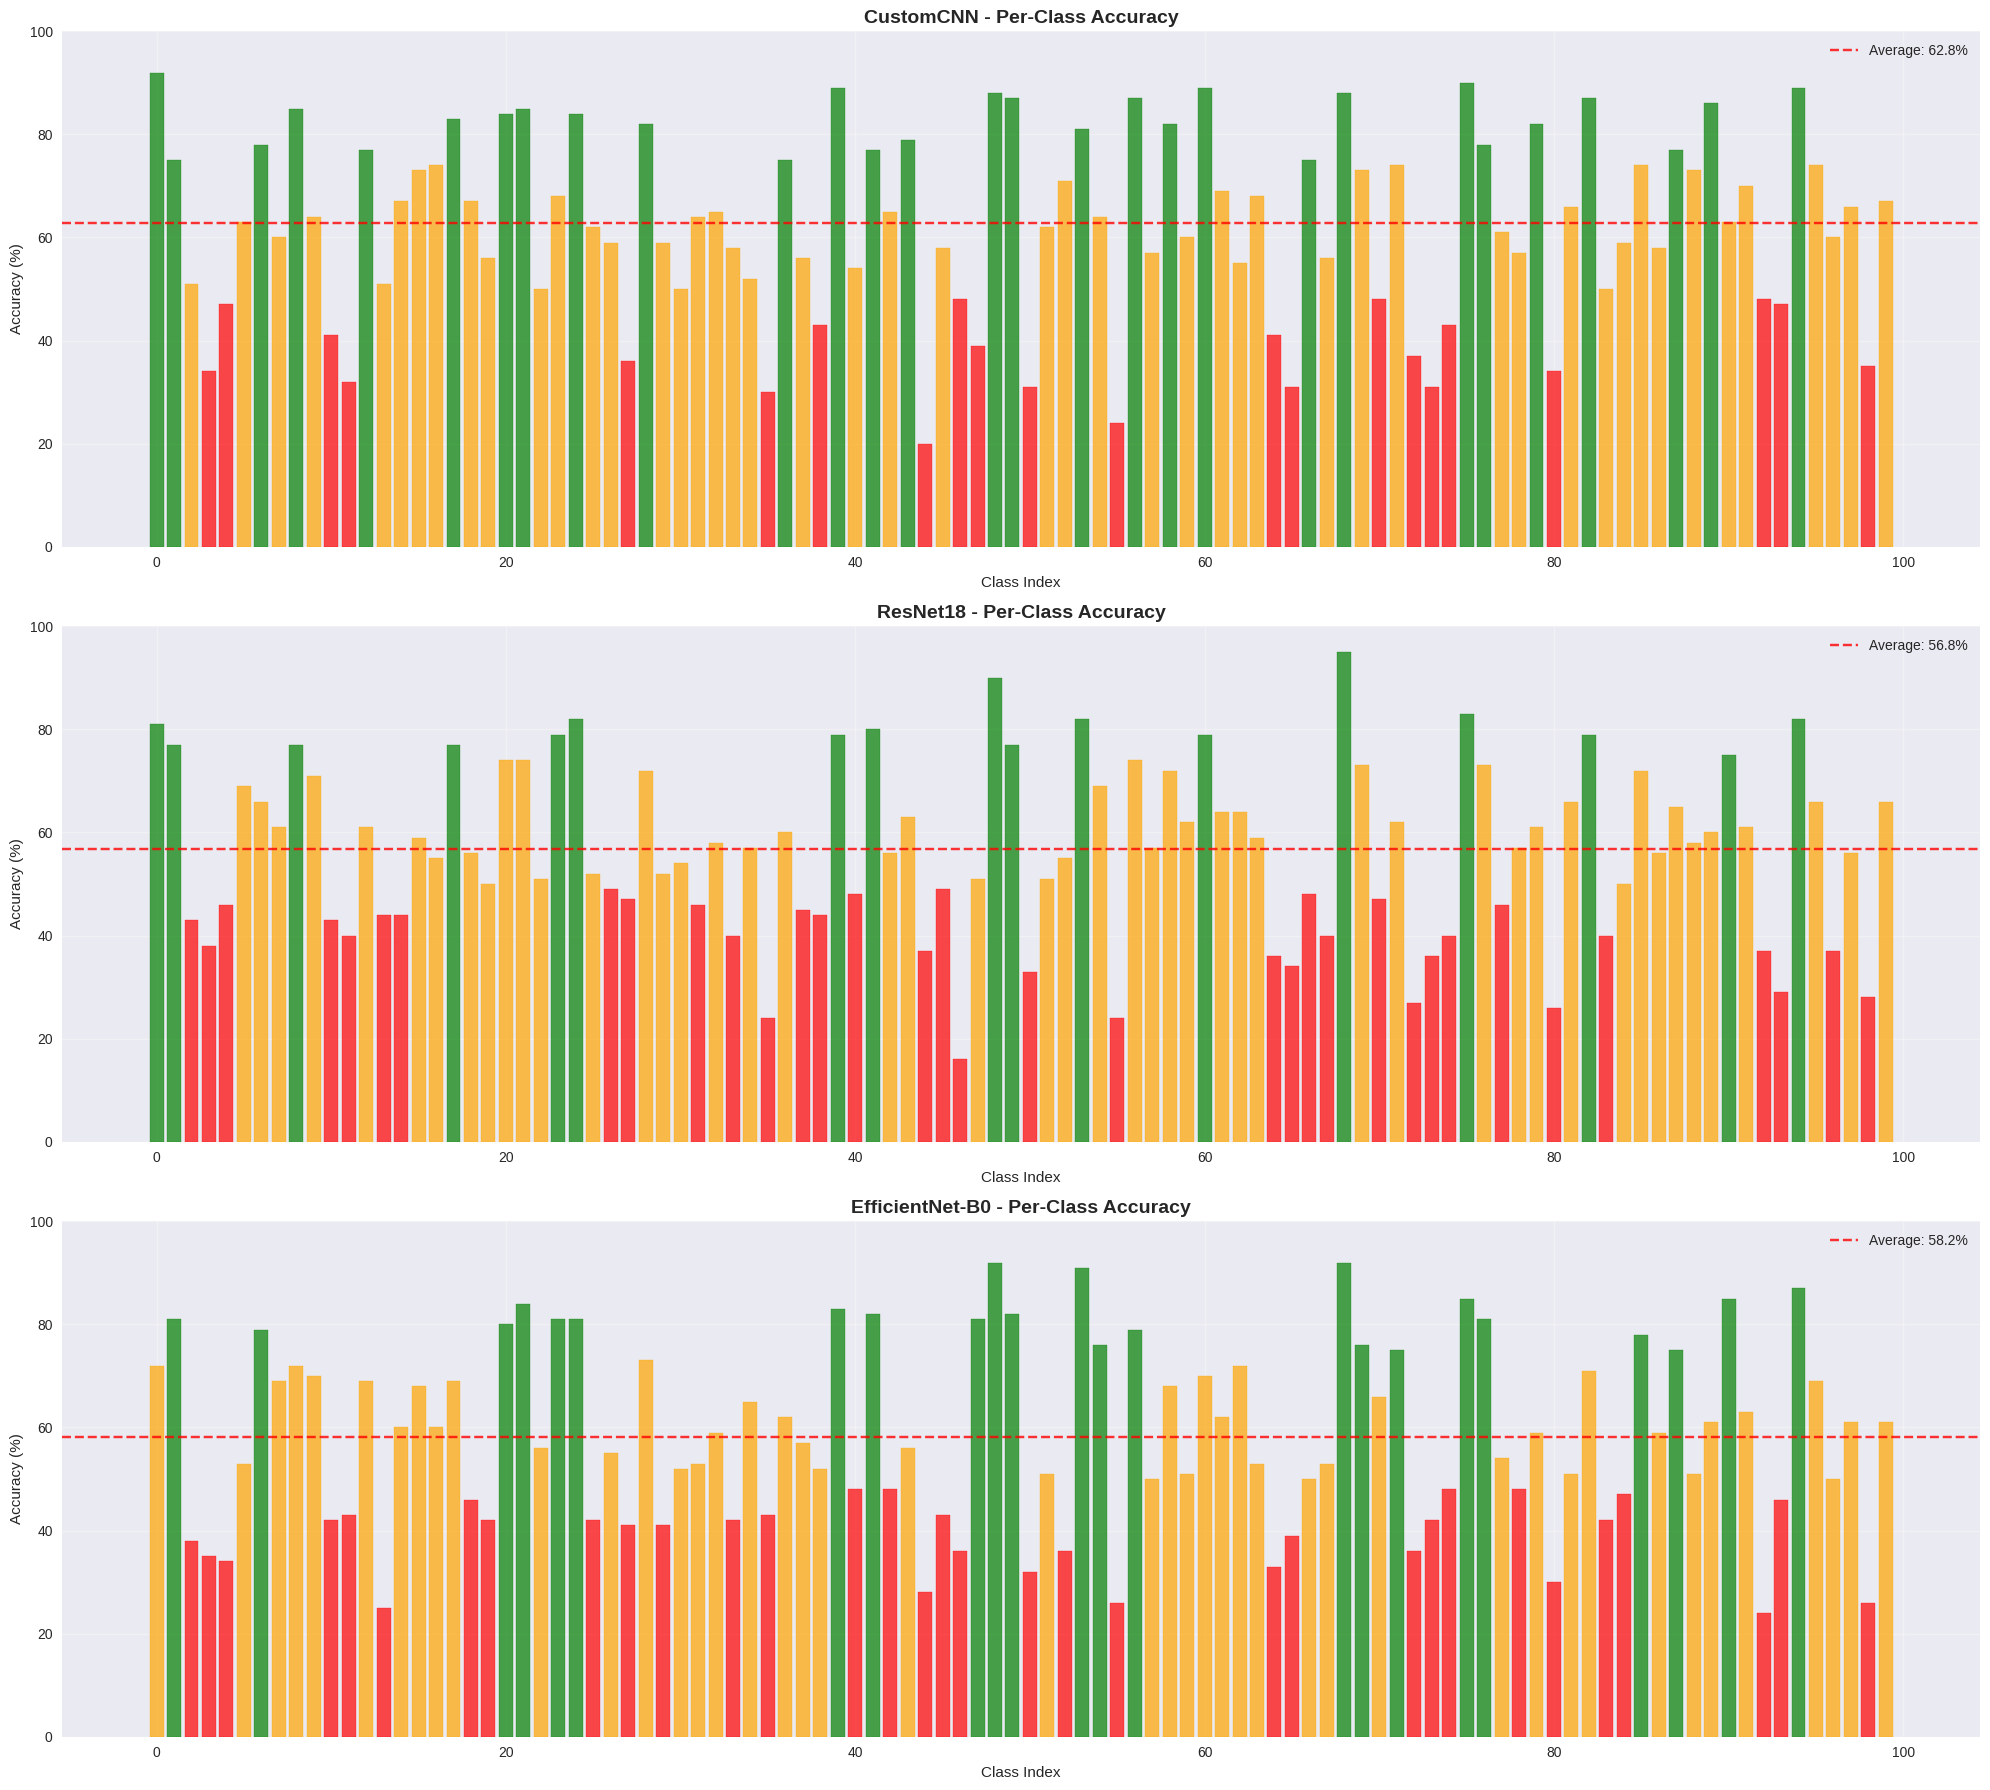

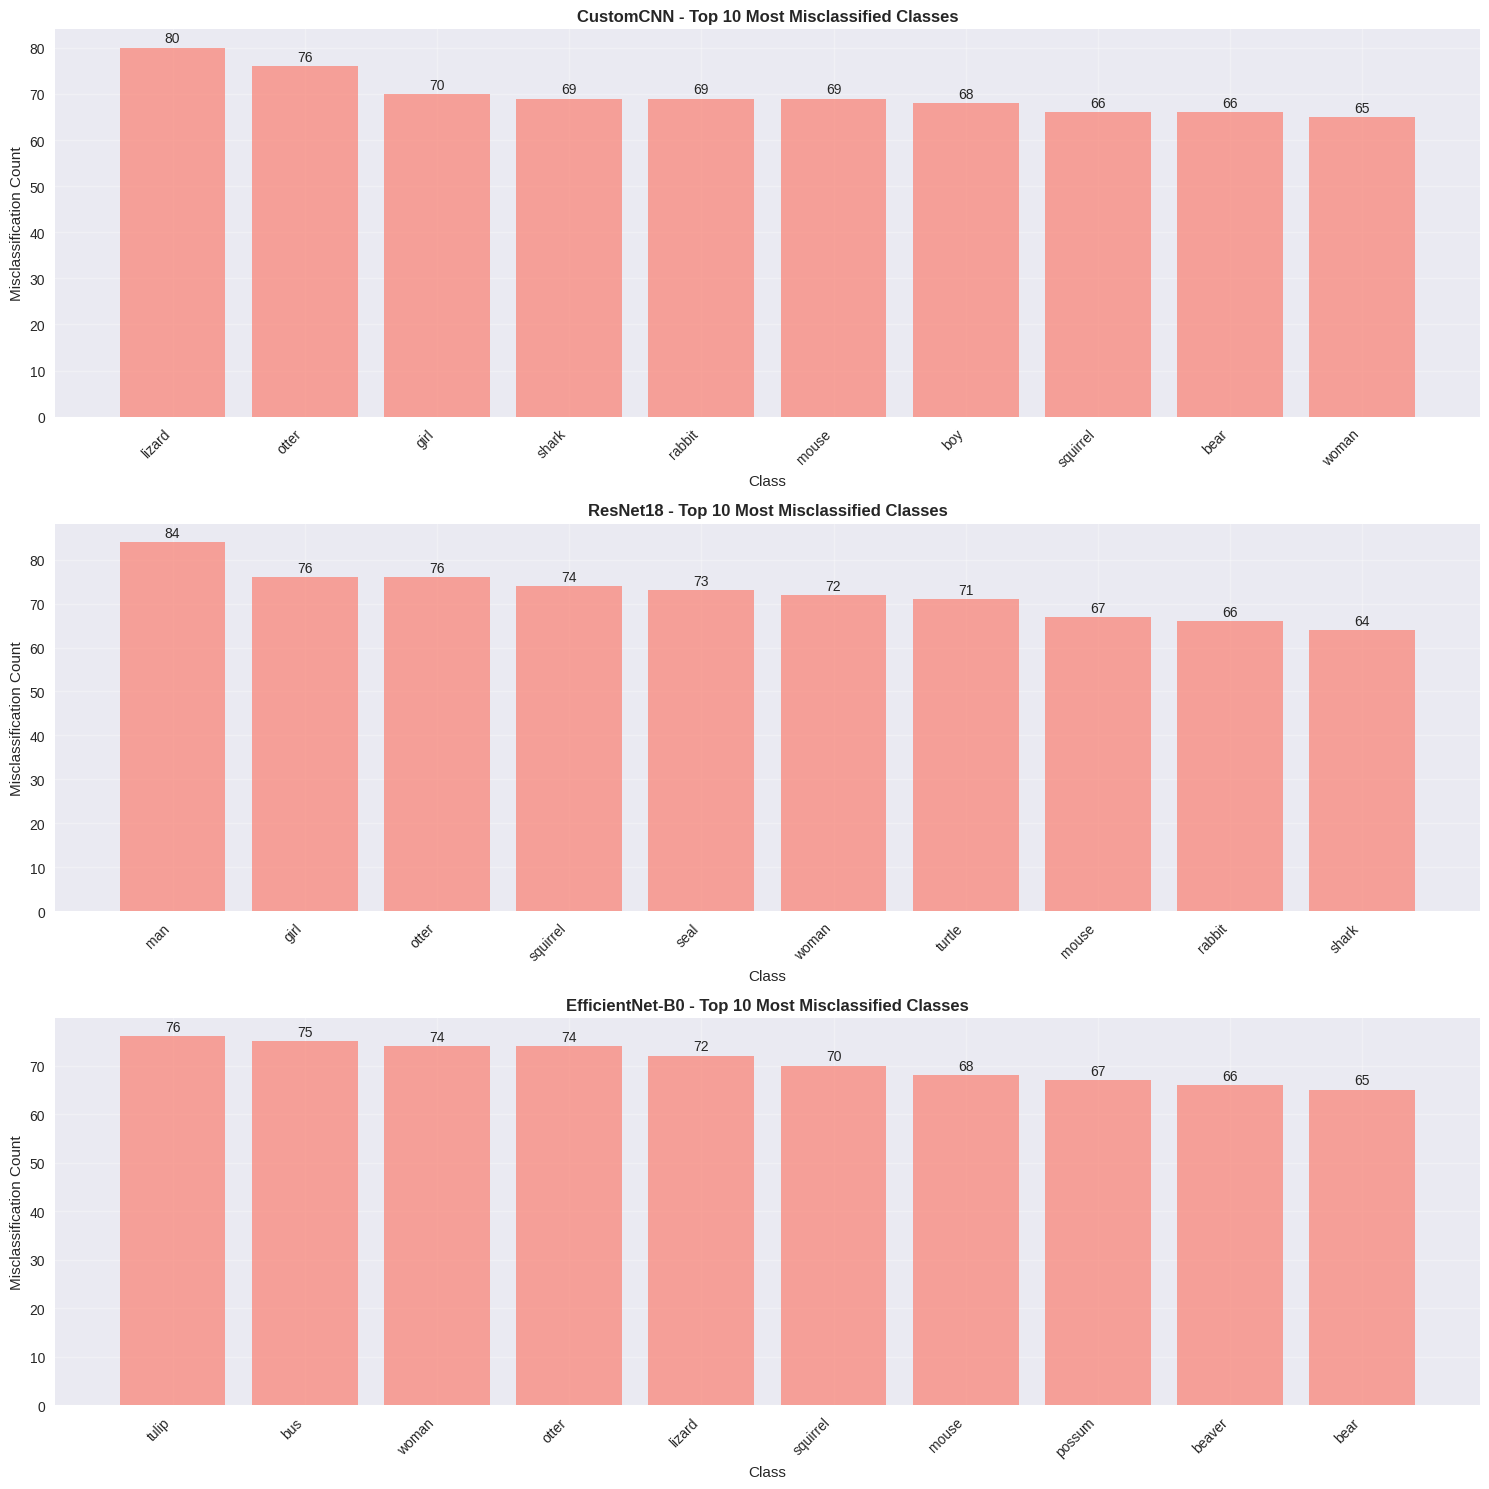

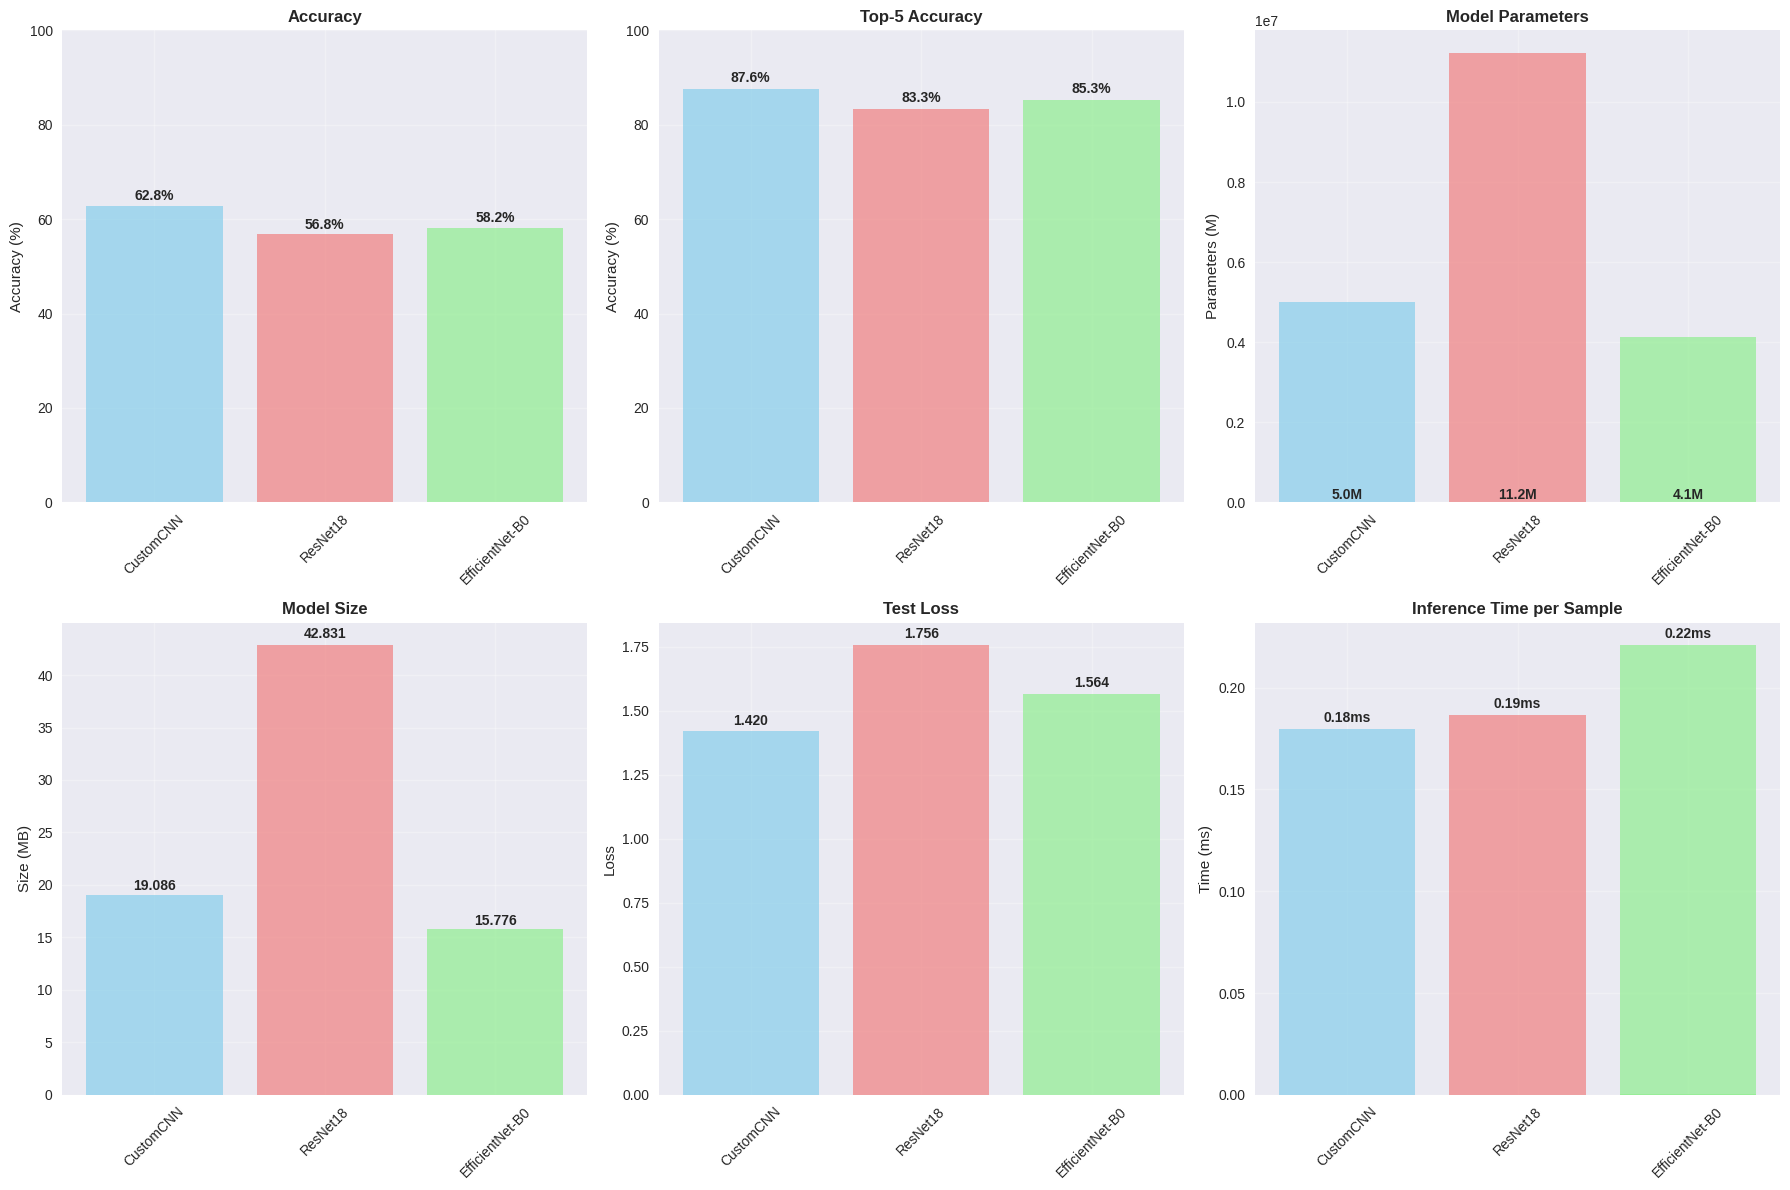

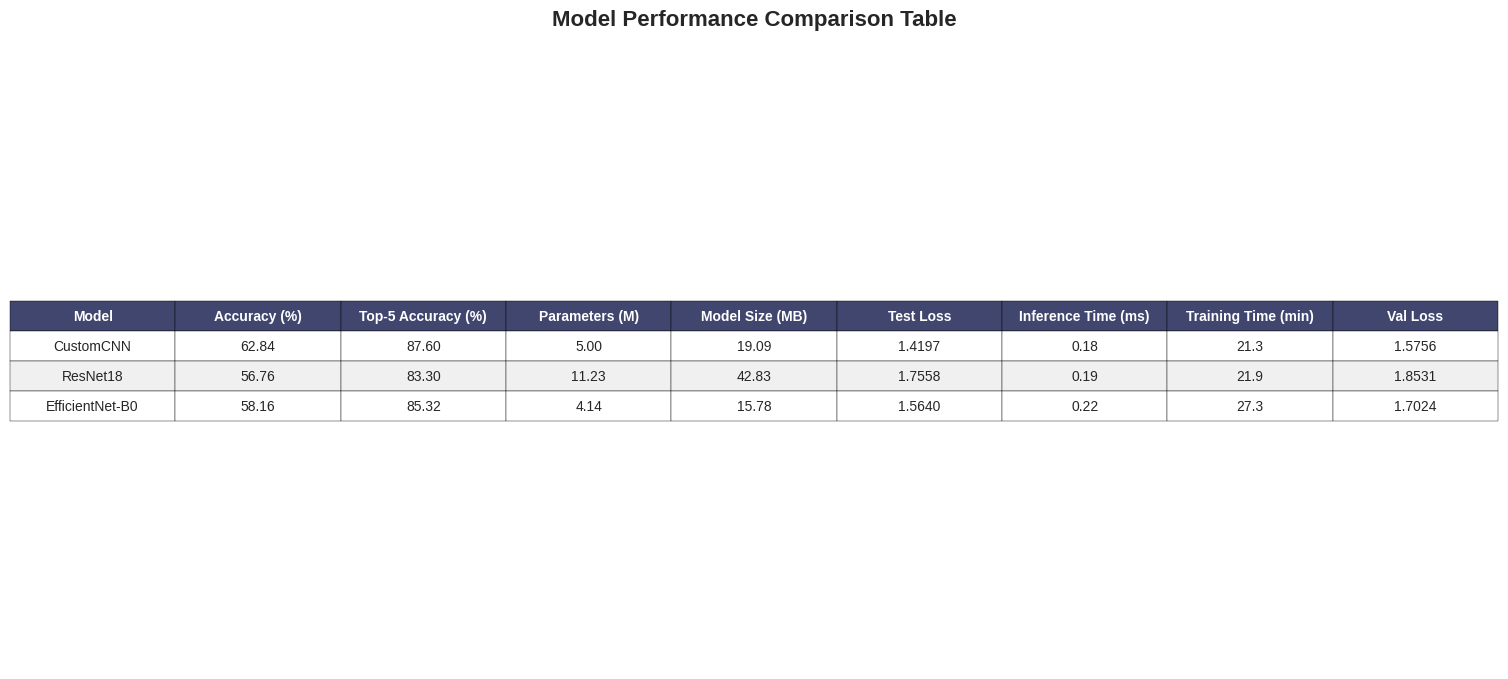

All plots saved to plots/ directory


In [12]:
# Generate all plots and analysis
analyzer.generate_all_plots()